In [0]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sns
from gensim.models import Word2Vec,FastText
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import nltk
from tqdm import tqdm
import random
import re


sns.set(color_codes=True)
torch.set_default_tensor_type('torch.DoubleTensor')

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
#method namayesh image

In [0]:
def clean_text(text):
    text = text.lower()
    return text

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batchSize = x.shape[0]
        return x.view(batchSize, -1)
      
flatten = Flatten()

In [0]:
#baraye flat kardan tensor ha dar sequential

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),torchvision.transforms.ToTensor(),torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


In [0]:
trainset = torchvision.datasets.Flickr30k(root="flickr30k-images",ann_file="results_20130124.token",transform=transform)



In [14]:
dataset_size = len(trainset)
indices = list(range(dataset_size))
sample = int(np.floor(0.16*dataset_size))
print(dataset_size)
print(sample)

31783
5085


In [0]:
np.random.seed(seed = 100)
np.random.shuffle(indices)

sample_indices = indices[:sample]

sample_sampler = torch.utils.data.sampler.SubsetRandomSampler(sample_indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,sampler=sample_sampler)

In [0]:
#taghsim dade ha be 1/6 va be tedad e 5k

In [18]:
image, caption = next(iter(trainloader))
print("shape of captions "+str(np.array(caption).shape))


shape of captions(5, 16)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


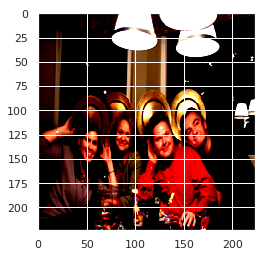

array(['Two men and women pose for a camera with large gold plates held behind their heads .',
       'Four people smile and hold golden plates behind their heads .',
       'Two men and two women hold gold plates behind their heads .',
       'Four people make a silly pose at the dinner table .',
       'friends posing for a picture while holding plates'], dtype='<U144')

In [20]:
imshow(image[0])
np.array(caption).T[0]

In [0]:
featureExtractor=torchvision.models.resnet50(pretrained=True, progress=True)
featureExtractor = torch.nn.Sequential(*list(featureExtractor.children())[:-1])
for param in featureExtractor.parameters():
    featureExtractor.requires_grad = False
featureExtractor=featureExtractor.eval()
featureExtractor=featureExtractor.to(device)


In [0]:
#baraye estekhraj e Image feature az shabake Resnet50 estefade kardim k yek bordar 2048 be ezaye har aks be ma midahad

In [23]:


caption_dict=dict()
file=open(r'results_20130124.token',encoding = 'utf-8').read().split("\n")
for line in file:
    _line=line.split("\t")
    if len(_line)==2:
        if _line[0].split(".")[0] not in caption_dict.keys():
            caption_dict[_line[0].split(".")[0]]=list()
            caption_dict[_line[0].split(".")[0]].append("<s> "+_line[1])
        else:
            caption_dict[_line[0].split(".")[0]].append("<s> "+_line[1])



listOfCaption = list(caption_dict.values())

#print(listOfCAption[:100])

noTokens = []

for _ in listOfCaption:
    for __ in _:
        noTokens.append(len(__.split(" ")))



#print(noTokens[:100])
print("maximum lentgh of captions {}".format(max(noTokens)))
print("minimum lentgh of captions {}".format(min(noTokens)))

print("median of caption lentgh {}".format(statistics.median(noTokens)))
print("mean of caption lentgh {}".format(sum(noTokens) / float(len(noTokens))))
print("std of caption lentgh {}".format(statistics.stdev(noTokens)))

maximum lentgh of captions 83
minimum lentgh of captions 3
median of caption lentgh 13
mean of caption lentgh 14.389440896076518
std of caption lentgh 5.4210709626294795


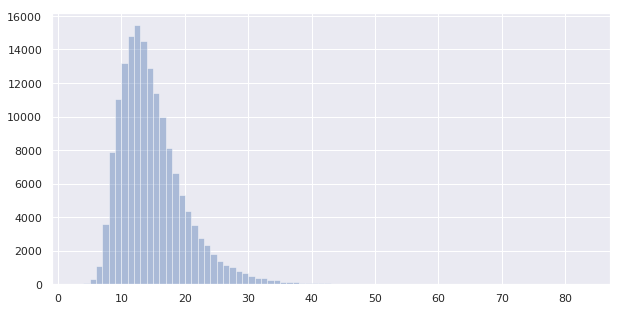

In [24]:
plt.figure(figsize=(10,5))
sns.distplot(noTokens,kde=False,bins=80)


In [25]:
list(caption_dict.values())[:2]

[['<s> Two young guys with shaggy hair look at their hands while hanging out in the yard .',
  '<s> Two young , White males are outside near many bushes .',
  '<s> Two men in green shirts are standing in a yard .',
  '<s> A man in a blue shirt standing in a garden .',
  '<s> Two friends enjoy time spent together .'],
 ['<s> Several men in hard hats are operating a giant pulley system .',
  '<s> Workers look down from up above on a piece of equipment .',
  '<s> Two men working on a machine wearing hard hats .',
  '<s> Four men on top of a tall structure .',
  '<s> Three men on a large rig .']]

In [26]:
corpus=[]
for _ in tqdm(list(caption_dict.values())):
  for __ in _:
      corpus.append(clean_text(__))
    


100%|██████████| 31783/31783 [00:00<00:00, 300839.88it/s]


In [27]:
corpus[0]

'<s> two young guys with shaggy hair look at their hands while hanging out in the yard .'

In [0]:
word2count = {}
for line in corpus:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

In [31]:
list(word2count.items())[:10]

[('<s>', 158915),
 ('two', 21641),
 ('young', 13218),
 ('guys', 658),
 ('with', 36207),
 ('shaggy', 51),
 ('hair', 2221),
 ('look', 1328),
 ('at', 16258),
 ('their', 4037)]

In [32]:
print("number of unique words in captions")
len(word2count.keys())

number of unique words in captions


20325

In [0]:
sentences_ted=[]           
for line in corpus:
    sentences_ted.append(line.split())

In [0]:
model = FastText(size=100, min_count=0,workers=-1,window=3)
model.build_vocab(sentences_ted)
model.train(sentences_ted, total_examples=len(word2count.keys()), epochs=100)

In [35]:
model.wv.most_similar("man")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('stuntman', 0.4894837439060211),
 ('lineman', 0.4642064571380615),
 ('ironman', 0.44262227416038513),
 ('seaman', 0.4198717772960663),
 ('commit', 0.38191133737564087),
 ('airman', 0.3732110559940338),
 ('batman', 0.37030720710754395),
 ('resourceful', 0.36943912506103516),
 ('stucco', 0.3678179979324341),
 ('mountian', 0.3625473976135254)]

In [0]:
#sakht model fasttext barae word embbeding vali deghat jaleb nist --> ???

In [0]:
def prepareBatch(images,captions,model_wv,maxLentgh,embedDim):
  batchSize = images.size()[0]
  extractedFeatures=featureExtractor(images.to(device)).view(batchSize,-1)
  embeddCapMatrix = np.zeros((batchSize,maxLentgh,embedDim))
  for i in range(batchSize):
    temp = np.zeros((maxLentgh,embedDim))
    chosenIndex=random.randint(0,captions[i].shape[0]-1)
    caption ="<s> "+clean_text(captions[i][chosenIndex])
    _capsList = caption.split()
    if len(_capsList) < maxLentgh:
      for j in range(len(_capsList)):
        try:
          temp[j,:] = model_wv.wv.get_vector(_capsList[j])
        except:
          temp[j,:] = np.zeros((1,embedDim))            
    else:
      for j in range(maxLentgh):
        try:
          temp[j,:] = model_wv.wv.get_vector(_capsList[j])
        except:
          temp[j,:] = np.zeros((1,embedDim))
    embeddCapMatrix[i,:,:] = temp  
  embeddCapMatrix = embeddCapMatrix.reshape(batchSize,1,maxLentgh,embedDim)
  return (extractedFeatures.double(),torch.from_numpy(embeddCapMatrix).double())

In [0]:
#method amade sazi batch ha k dar nahat khoroji an be ezaye har aks ye bordar vijegi va yek matrix az word embedding ha 

In [0]:
IF,cap = prepareBatch(image.double(),np.array(caption).T,model,30,100)

In [41]:
IF.shape

torch.Size([16, 2048])

In [42]:
cap.shape

torch.Size([16, 1, 30, 100])

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
      torch.nn.init.constant_(m.bias.data, 0)
      torch.nn.init.normal_(m.weight.data)

In [0]:
#method vazn dehi be shabake ha dar tozi normal

In [0]:
class Generator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.down = torch.nn.Sequential(
        torch.nn.Linear(2048,1024),
        torch.nn.LeakyReLU(True),
        torch.nn.BatchNorm1d(1024),
        torch.nn.Linear(1024,512),
        torch.nn.LeakyReLU(True),
        torch.nn.BatchNorm1d(512))
        
    self.main = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(1,128,(4,34), bias=True),
        torch.nn.BatchNorm2d(128),
        torch.nn.LeakyReLU(True),
        torch.nn.ConvTranspose2d(128,64,(4,16), bias=True),
        torch.nn.BatchNorm2d(64),
        torch.nn.LeakyReLU(True),
        torch.nn.ConvTranspose2d(64,32,(4,8), bias=True),
        torch.nn.BatchNorm2d(32),
        torch.nn.LeakyReLU(True),
        torch.nn.ConvTranspose2d(32,16,(4,8), bias=True),
        torch.nn.BatchNorm2d(16),
        torch.nn.LeakyReLU(True),
        torch.nn.ConvTranspose2d(16,8,(2,4), bias=True),
        torch.nn.BatchNorm2d(8),
        torch.nn.LeakyReLU(True),
        torch.nn.ConvTranspose2d(8,1,(2,4), bias=True),
        torch.nn.Tanh())
    
  def forward(self,input):
    batchSize = input.shape[0]
    input = input.to(device)
    input = self.down(input)
    input = input.view(batchSize,1,16,32)
    return self.main(input)
  
  
class Discriminator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.main = torch.nn.Sequential(
        torch.nn.Conv2d(1,256,(2,32), bias=True),
        torch.nn.BatchNorm2d(256),
        torch.nn.LeakyReLU(True),
        torch.nn.Conv2d(256,128,(2,32), bias=True),
        torch.nn.BatchNorm2d(128),
        torch.nn.LeakyReLU(True),
        torch.nn.Conv2d(128,32,(2,16), bias=True),
        torch.nn.BatchNorm2d(32),
        torch.nn.LeakyReLU(True),
        torch.nn.Conv2d(32,16,(2,16), bias=True),
        torch.nn.BatchNorm2d(16),
        torch.nn.LeakyReLU(True),
        torch.nn.Conv2d(16,1,(2,8), bias=True),
        torch.nn.BatchNorm2d(1),
        torch.nn.LeakyReLU(True),
        flatten,
        torch.nn.Linear(25,1),
        torch.nn.Sigmoid())
    
  def forward(self,input):
    return self.main(input)


In [0]:
#akharin model azmayesh shode

In [0]:
generator = Generator()
generator=generator.apply(weights_init)
discriminator = Discriminator()
discriminator=discriminator.apply(weights_init)

In [0]:
criterion = torch.nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=5e-5)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=5e-5)

In [0]:
discriminator=discriminator.to(device)
generator=generator.to(device)

In [0]:
num_epochs = 20

Gerr = []
Derr = []


for epoch in range(num_epochs):
  for i, (images, caps) in enumerate(trainloader):
    batchsize = images.shape[0]
    Ginput,Dinput=prepareBatch(images.double().to(device),np.array(caps).T,model,30,100)
    
    discriminator.zero_grad()   
    target = torch.ones((batchsize,1),requires_grad=False).to(device).double()
    output = discriminator(Dinput.to(device))
    errD_real = criterion(output, target)
    
    
    fake = generator(Ginput)
    target = torch.zeros((batchsize,1),requires_grad=False).to(device).double()
    output = discriminator(fake.detach().to(device))
    errD_fake = criterion(output, target)
    
    errD = errD_real + errD_fake
    errD.backward()
    
    
    
    for p in list(filter(lambda p: p.grad is not None, discriminator.parameters())):
      if p.grad.data.norm(2).item() > 100:        
        print("Norm of Gradients in D is higher than 100")
      
    torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 100)
    d_optimizer.step()
    
    generator.zero_grad()
    target = torch.ones((batchsize,1),requires_grad=False).to(device).double()
    output = discriminator(fake.to(device))
    errG = criterion(output, target)
    errG.backward()
    for p in list(filter(lambda p: p.grad is not None, generator.parameters())):
      if p.grad.data.norm(2).item() > 100:        
        print("Norm of Gradients in G is higher than 100")
        
    torch.nn.utils.clip_grad_norm_(generator.parameters(), 100)
    g_optimizer.step()
    
    
    #G_loss_batch += errG.item()*batchsize
    
    
    Gerr.append(errG.item())
    Derr.append(errD.item())
    
    if i%10 == 0:
      print ("batch number of {0} in epoch {1}: D Error --> {2} and G Error {3}".format(i,epoch,errD,errG))
      

In [49]:
'''
toye in model bad az 20 epoch nemudar loss be in shekl shod (file zip) va hamchenin generator in 
caption ra tolid kard

generated cap ->


' smocks similarly-dressed anticipated cain sharon mid-kick 
riverside black-blue fourwheeler woamn powerboats daft chokes 
given jester frail vandalism rickshaws buns cellist elaborate 
mast freemont chug spunky goat rid 745 graveled muddied'

true caps ->

['There are seven children jumping for joy on a grass hill .',
       '7 young boys celebrating on top of a grass covered hill .',
       'Seven children all jump as the photo is taken .',
       'Seven children are jumping in a grassy meadow .',
       'five kids jumping for no real reason']
       
       

'''

"\ntoye in model bad az 20 epoch nemudar loss be in shekl shod (file zip) va hamchenin generator in \ncaption ra tolid kard\n\ngenerated cap ->\n\n\n' smocks similarly-dressed anticipated cain sharon mid-kick \nriverside black-blue fourwheeler woamn powerboats daft chokes \ngiven jester frail vandalism rickshaws buns cellist elaborate \nmast freemont chug spunky goat rid 745 graveled muddied'\n\ntrue caps ->\n\n['There are seven children jumping for joy on a grass hill .',\n       '7 young boys celebrating on top of a grass covered hill .',\n       'Seven children all jump as the photo is taken .',\n       'Seven children are jumping in a grassy meadow .',\n       'five kids jumping for no real reason']\n       \n       \n\n"